In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from time import time

%matplotlib inline

In [2]:
file = pd.ExcelFile('dataPoints.xlsx')
df = file.parse('Foglio1')
df.head()

X = df[['x1', 'x2']].to_numpy()
y_true = df[['y']].to_numpy().reshape(1,-1)

X_train, X_test, y_train, y_test = train_test_split(X, y_true.reshape(-1,1), test_size=0.15, 
                                                    random_state=1869097)

y_train = y_train.reshape(1,-1)
y_test = y_test.reshape(1,-1)

In [3]:
def g_fun(T, sigma):
    num = np.exp(2*sigma*T) - 1
    den = np.exp(2*sigma*T) + 1
    return num / den

def convex_fun(X, v, W, b):
    
    # creating matrix X1 (X matrix plus array of ones)
    X1 = np.append(X, -1* np.ones((X.shape[0], 1)), axis=1)
    return np.dot(v.T, g_fun(np.dot(Wb, np.transpose(X1)), sigma))

def convex_Grad(v, X_train, y_true, W, b):
    
    # merge W with b
    Wb = np.append(W, b, axis=1)
    
    # creating matrix X1 (X matrix plus array of ones)
    X1 = np.append(X_train, -1* np.ones((X_train.shape[0],1)), axis=1)

    # pick parameters from o
    v = v.reshape(N,1)
    omega = v.reshape(1,N)
        
    ### compute partial derivatives in a "pythonic" way:
    
    # for the sake of clearness, let's define some variables
    # (MATRIX1) dot product between Wb and X1
    T = np.dot(Wb, np.transpose(X1)) # NxX_train.shape[0] matrix
    
    # derivative of g()
    #g_der = 4 * sigma * np.exp(2 * sigma * T) / (np.exp(2 * sigma * T) + 1)**2

    dE_dv = 1 / X_train.shape[0] * np.dot(g_fun(T, sigma), \
                                          np.transpose(convex_fun(X_train, v, W, b) - y_true)) + 2 * rho * v

    return dE_dv.reshape(-1)

def convex_loss(v, X, y_true, W, b):
    y_pred = convex_fun(X, v, W, b)
    l = np.sum((y_pred - y_true)**2)/(2 * X.shape[0]) + rho * np.linalg.norm(v)**2
    loss_history.append(l)
    return l


def non_convex_loss(omega, X, y_true, v):
    y_pred = non_convex_fun(X, omega, v)
    l = np.sum((y_pred - y_true)**2)/(2 * X.shape[0]) + rho * np.linalg.norm(omega)**2
    loss_history.append(l)
    return l


def non_convex_fun(X, omega, v):  
    # creating matrix X1 (X matrix plus array of ones)
    X1 = np.append(X, -1* np.ones((X.shape[0], 1)), axis=1)

    # extract param vectors from omega
    W = omega[0:n*N].reshape(N, n)
    b = omega[n*N:].reshape(N, 1)
    
    # merge W with b
    Wb = np.append(W, b, axis=1)
    return np.dot(v.T, g_fun(np.dot(Wb, np.transpose(X1)), sigma))

def non_convex_Grad(omega, X_train, y_true, v):
    
    # creating matrix X1 (X matrix plus array of ones)
    X1 = np.append(X_train, -1* np.ones((X_train.shape[0],1)), axis=1)

    # pick parameters from omega one
    v = v.reshape(N,1)
    W = omega[0:n*N].reshape(N, n)
    b = omega[n*N:].reshape(N, 1)
    
    
    Wb = np.append(W,b, axis=1)
    
    ### compute partial derivatives in a "pythonic" way:
    
    # for the sake of clearness, let's define some variables
    # (MATRIX1) dot product between Wb and X1
    T = np.dot(Wb, np.transpose(X1)) # NxX_train.shape[0] matrix
    
    # derivative of g()
    g_der = 4 * sigma * np.exp(2 * sigma * T) / (np.exp(2 * sigma * T) + 1)**2

    #dE_dv = 1 / X_train.shape[0] * np.dot(g_fun(T, sigma), np.transpose(fun(X_train, omega) - y_true)) + 2 * rho * v
    dE_db = 1 / X_train.shape[0] * np.dot(-1 * v * g_der, \
                                          np.transpose(non_convex_fun(X_train, omega, v) - y_true)) + 2 * rho * b
    
    # dealing with dE_dW
    mat1 = v * g_der * X1[:,0]
    mat1 = np.dot(mat1, np.transpose(non_convex_fun(X_train, omega, v) - y_true))
    mat2 = v * g_der * X1[:,1]
    mat2 = np.dot(mat2, np.transpose(non_convex_fun(X_train, omega, v) - y_true))

    fusion = np.append(mat1, mat2, axis=1)
    dE_dW = 1 / X_train.shape[0] * fusion + 2 * rho * W

    omega_gradient = np.concatenate((dE_dW.reshape(N*n,1), dE_db))
    return omega_gradient.reshape(-1)

def MLP_fun(X, omega):
    
    # creating matrix X1 (X matrix plus array of ones)
    X1 = np.append(X, -1* np.ones((X.shape[0], 1)), axis=1)

    # extract param vectors from omega
    v = omega[0:N].reshape(N, 1)
    W = omega[N:3*N].reshape(N, n)
    b = omega[3*N:].reshape(N,1)
    
    # merge W with b
    Wb = np.append(W, b, axis=1)
    
    return np.dot(v.T, g_fun(np.dot(Wb, np.transpose(X1)), sigma))

def MLP_loss(omega, X, y_true):
    y_pred = MLP_fun(X, omega)
    l = np.sum((y_pred - y_true)**2)/(2 * X.shape[0]) + rho * np.linalg.norm(v)**2
    loss_history.append(l)
    return l

In [4]:
file = pd.ExcelFile('dataPoints.xlsx')
df = file.parse('Foglio1')
df.head()

X = df[['x1', 'x2']].to_numpy()
y_true = df[['y']].to_numpy().reshape(1,-1)

X_train, X_test, y_train, y_test = train_test_split(X, y_true.reshape(-1,1), test_size=0.15, 
                                                    random_state=1869097)

y_train = y_train.reshape(1,-1)
y_test = y_test.reshape(1,-1)

In [5]:
N = 25
n = np.shape(X)[1]
sigma = 1.8
rho = 0.00001


loss_history = []

W = np.random.randn(N,n)
b = np.random.randn(N,1)
v = np.random.randn(N,1)

# merge W with b
Wb = np.append(W, b, axis=1)

t1 = time()
res = minimize(convex_loss, v, jac = convex_Grad, args=(X_train, y_train, W, b), method = "BFGS")#,
               #options = {"maxiter": 50, "gtol":1e-2})
t1 = time()-t1
print(t1)

0.1589822769165039


In [6]:
print(res.message)
print('exec time:', t1)
print('fun:', res.fun)
print('success:',res.success)
print('nfev:', res.nfev)
print('nit:', res.nit)
print('njev:', res.njev)

Optimization terminated successfully.
exec time: 0.1589822769165039
fun: 0.06837853259511455
success: True
nfev: 175
nit: 173
njev: 175


In [7]:
# save the result 
v_star = res.x.copy().reshape(-1,1)

In [8]:
#create_omega
omega = np.concatenate((W.reshape(N*n, 1), b)).reshape(-1)
print(omega.shape)

(75,)


In [9]:
print(non_convex_Grad(omega, X_train, y_train, v_star).shape)
print(W.shape[0]*W.shape[1] + b.shape[0]) # check if it's the same.. OK! 

(75,)
75


In [10]:
non_convex_loss(omega, X, y_true, v_star)

0.06844801155149204

In [11]:
t1 = time()
res = minimize(non_convex_loss, omega, jac = non_convex_Grad, args=(X_train, y_train, v_star), method = "BFGS")
t1 = time() - t1

In [12]:
print(res.message)
print('exec time:', t1)
print('fun:', res.fun)
print('success:',res.success)
print('nfev:', res.nfev)
print('nit:', res.nit)
print('njev:', res.njev)

Optimization terminated successfully.
exec time: 1.6544098854064941
fun: 0.0036350432159268377
success: True
nfev: 921
nit: 900
njev: 921


In [13]:
# losses
v_star
W_and_b_star = res.x

W_star = res.x[0:n*N].reshape(N, n)
b_star = res.x[n*N:].reshape(N,1)

print('---- Convex loss ----')
print('train:', convex_loss(v_star, X_train, y_train, W_star, b_star))
print('test:', convex_loss(v_star, X_test, y_test, W_star, b_star), '\n')


print('---- Non Convex loss ----')
print('train:', non_convex_loss(res.x, X_train, y_train, v_star))
print('test:', non_convex_loss(res.x, X_test, y_test, v_star), '\n')



omega_star = np.concatenate((v.reshape(-1,1), W.reshape(N*n,1), b)).reshape(-1)

print('---- Overall loss ----')
print('train:', MLP_loss(omega_star, X_train, y_train))
print('test:', MLP_loss(omega_star, X_test, y_test))

---- Convex loss ----
train: 0.06837853259511455
test: 0.09139268768949899 

---- Non Convex loss ----
train: 0.0036350432159268377
test: 0.004340370604363919 

---- Overall loss ----
train: 23.622806027603502
test: 18.988180981496924


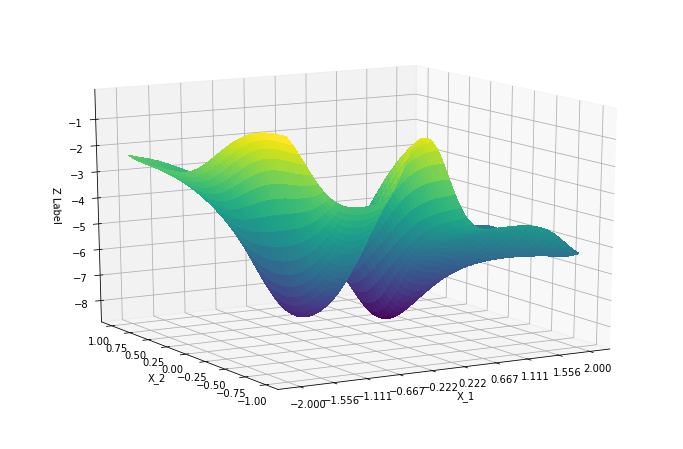

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

X_1 = np.linspace(-2,2,500)
X_2 = np.linspace(-1,1,500)
X_1, X_2 = np.meshgrid(X_1, X_2)
zs = np.array([MLP_fun(np.array([x,y]).reshape(1,2), omega_star) for x,y in zip(np.ravel(X_1), np.ravel(X_2))])
Z = zs.reshape(X_1.shape)
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
ax.plot_surface(X_1, X_2, Z ,linewidth=0,cmap=cm.viridis, antialiased=False)
ax.set_xticks((np.linspace(-2,2,10)))
ax.view_init(elev=15, azim=240)
ax.set_xlabel('X_1')
ax.set_ylabel('X_2')
ax.set_zlabel('Z Label')
plt.savefig('graph_question_1_1.png',dpi=600)
plt.show()